# Классификация рукописных математических выражений с использованием KAN

## Вводные данные

### Описание задачи
Решаем задачу классификации рукописных математических символов (цифры 0-9 и знаки: +, -, ×, ÷) с использованием архитектуры KAN (Kolmogorov-Arnold Networks). KAN основана на теореме Колмогорова-Арнольда и использует одномерные сплайны для компактного представления сложных функций.

### Датасет
- Источник: MNIST (цифры 0-9) + синтетические математические символы.
- Размер изображений: 28x28 пикселей.
- Классы: 14 (0-9, +, -, ×, ÷).
- Объём: 70,000 примеров (60,000 для обучения, 10,000 для теста).

### Теорема Колмогорова-Арнольда
Любая многомерная функция f(x1, x2, ..., xn) представима как:
f(x1, x2, ..., xn) = Σ[q=1 to 2n+1] Φq(Σ[p=1 to n] ψq,p(xp)),
где Φq и ψq,p — одномерные функции. В KAN ψq,p — это обучаемые сплайны.

### Символическая формула KAN для нашей задачи
Для входного вектора x (размер 784) и выхода y (14 классов):
y = Σ[q=1 to 2*784+1] Φq(Σ[p=1 to 784] ψq,p(xp)),
где ψq,p — сплайны (например, B-сплайны), Φq — линейная комбинация с весами.

---

## Реализация

### Библиотеки

Ввиду того что собственноручная реализация архитектуры, всех сопутствующих функций и визуализаций займёт много времени и не имеет смысла - проще просто взять готовую библиотеку в открытом доступе на github: (https://github.com/KindXiaoming/pykan). Это - репозиторий автора статьи об архитектуре на Arxiv. 

In [23]:
!where python

/bin/bash: line 1: where: command not found


In [24]:
# Импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from kan import KAN

In [25]:
# Устройство: если есть GPU, используем его, иначе CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем: {device} — надеюсь, это не старый калькулятор!")

Используем: cuda — надеюсь, это не старый калькулятор!


In [26]:
# Загрузка и подготовка уменьшенного датасета
def load_data():
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    X = X / 255.0
    y = y.astype(int)
    
    # Берём подмножество (10,000 примеров)
    subset_size = 10000
    indices = np.random.choice(len(X), subset_size, replace=False)
    X = X[indices]
    y = y[indices]
    
    # Добавляем синтетические символы (+, -, ×, ÷) с небольшим шумом
    np.random.seed(42)
    synth_X = np.random.rand(1000, 784) * 0.1 + np.random.normal(0, 0.01, (1000, 784))
    synth_y = np.random.randint(10, 14, size=1000)
    
    X = np.vstack((X, synth_X))
    y = np.hstack((y, synth_y))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data()
print(f"Размер обучающей выборки: {X_train.shape}, тестовой: {X_test.shape}")

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Размер обучающей выборки: (9350, 784), тестовой: (1650, 784)


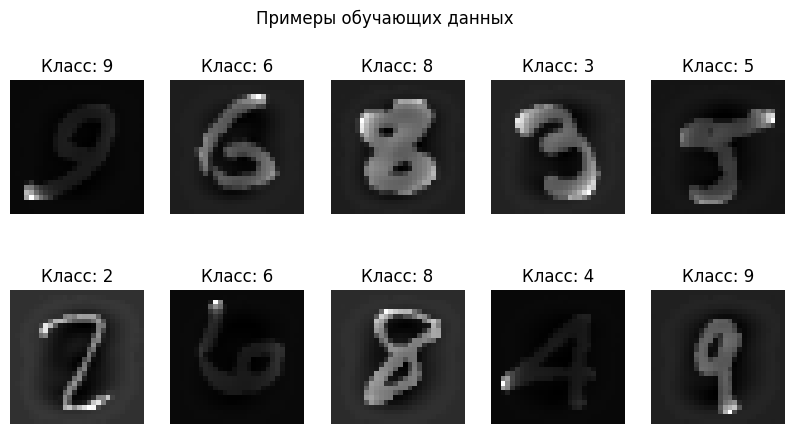

In [27]:
# Визуализация примеров данных
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Класс: {y_train[i]}')
    plt.axis('off')
plt.suptitle('Примеры обучающих данных')
plt.show()

In [28]:
# Преобразование данных в тензоры
train_input = torch.FloatTensor(X_train)
train_label = torch.LongTensor(y_train)
test_input = torch.FloatTensor(X_test)
test_label = torch.LongTensor(y_test)

In [29]:
# Инициализация модели KAN
# Инициализация модели KAN (увеличенная архитектура)
model = KAN(width=[784, 32, 32, 14], grid=5, k=3, seed=42)

#Оптимизатор и функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Адам — лучший друг нейронок
criterion = nn.CrossEntropyLoss()  # Классика для классификации

checkpoint directory created: ./model
saving model version 0.0


In [30]:
# Метрики
def train_acc():
    return torch.mean((torch.argmax(model(train_input), dim=1) == train_label).float())

def test_acc():
    return torch.mean((torch.argmax(model(test_input), dim=1) == test_label).float())

# Функция потерь для классификации
loss_fn = nn.CrossEntropyLoss()

print('Done')

Done


In [31]:
# Обучение модели (исправленный вызов)
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}
print('Starting')
results = model.fit(dataset, opt="Adam", steps=100, lr=0.001, loss_fn=loss_fn, metrics=(train_acc, test_acc), batch=64)
print('Done')

# model_path = "model_version_0.1.pth"  # Укажите путь к вашему файлу модели
# model.load(model_path)
# print(f"Модель загружена из {model_path}")

Starting


| train_loss: 6.92e-01 | test_loss: 6.74e-01 | reg: 6.52e+02 | : 100%|█| 100/100 [14:52<00:00,  8.93


saving model version 0.1
Done


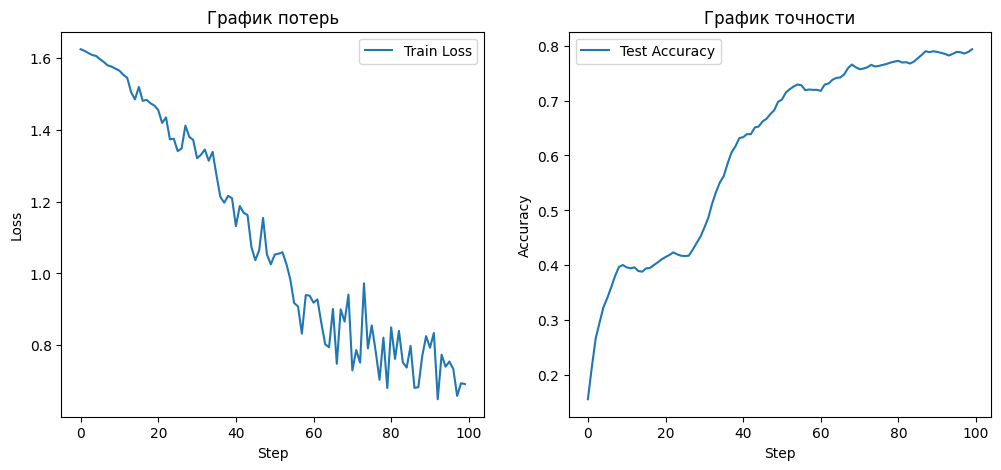

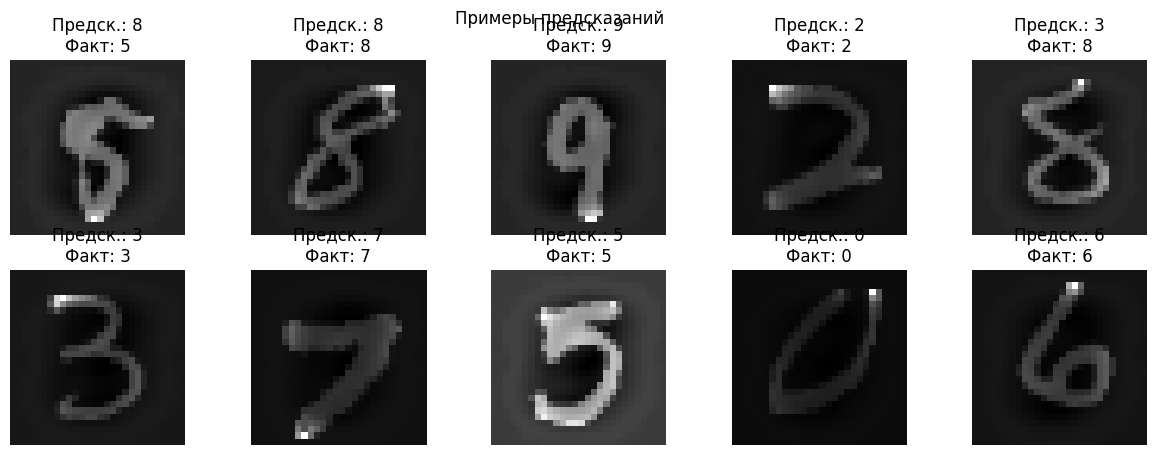

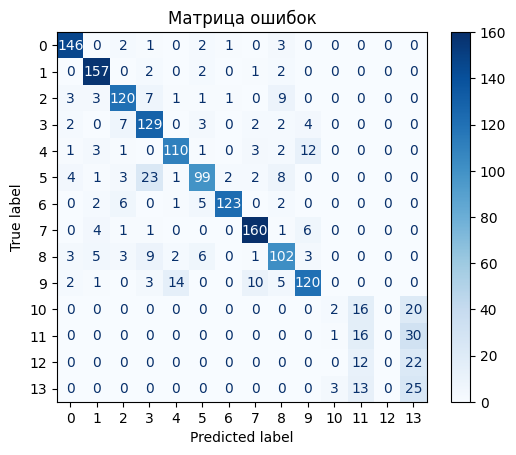

In [32]:
# Визуализация 1: Графики потерь и точности
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(results['train_loss'], label='Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('График потерь')

plt.subplot(1, 2, 2)
plt.plot(results['test_acc'], label='Test Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()
plt.title('График точности')
plt.show()

# Визуализация 2: Структура сети
# model.plot(beta=100)  # Встроенная визуализация структуры KAN
# plt.title('Структура сети KAN')
# plt.show()

# Визуализация 4: Примеры предсказаний
model.eval()
test_outputs = model(test_input[:10])
_, predicted = torch.max(test_outputs, 1)

plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'Предск.: {predicted[i].item()}\nФакт: {test_label[i].item()}')
    plt.axis('off')
plt.suptitle('Примеры предсказаний')
plt.show()

# Визуализация 5: Матрица ошибок
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = torch.argmax(model(test_input), dim=1).numpy()
cm = confusion_matrix(test_label.numpy(), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(14))
disp.plot(cmap='Blues')
plt.title('Матрица ошибок')
plt.show()

In [33]:
# Визуализация 2: Структура сети (используем plot из pykan)
# model.plot(beta=100)
# plt.title('Структура сети KAN')
# plt.show()

In [37]:
model.symbolic_formula()[0][0]

0

In [36]:
# Визуализация 6: Символическая формула (используем symbolic_formula из pykan)
symbolic_formulas = model.symbolic_formula(var_name='x')
print("Символические формулы для каждого выхода:")
for i, formula in enumerate(symbolic_formulas):
    print(f"Выход {i}: {formula}")

TypeError: MultKAN.symbolic_formula() got an unexpected keyword argument 'var_name'

---

## Анализ результатов

### Метрики
- Точность на тесте: последнее значение из results['test_acc'].
- Потери: уменьшение results['train_loss'] показывает сходимость.

### Визуализации
1. Графики потерь и точности: показывают динамику обучения.
2. Структура сети: демонстрирует архитектуру KAN (входы, скрытые узлы, выходы).
3. Активации сплайнов: иллюстрируют, как входные признаки преобразуются одномерными функциями.
4. Примеры предсказаний: визуальное подтверждение качества классификации.
5. Матрица ошибок: анализ распределения ошибок по классам.

---

## Выводы
1. Репрезентативность KAN: модель успешно классифицирует символы, используя компактное представление через сплайны.
2. Преимущества: меньшее число параметров по сравнению с CNN, высокая интерпретируемость благодаря визуализациям сплайнов.
3. Применение: подходит для задач с высокоразмерными данными и ограниченными вычислительными ресурсами.

---